In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
from pylab import plt
# the above line has the same effect as
#import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()

In [8]:
# Set an artificial time series with 1200 data points
df = np.linspace(0, 4*np.pi, 1200, dtype=np.float32)

In [9]:
# Generate sine curve
df=np.sin(df)
df=pd.DataFrame(df)

In [10]:
# For every data point, +/- some random values
df['close'] = df + np.random.rand(*df.shape) / 10.0
df["create_time"] = pd.date_range('01/01/2019 12:00:00',periods=len(df),freq='24H')

In [11]:
df = pd.Series(df['close'].values, index=df['create_time'])
df

create_time
2019-01-01 12:00:00    0.098159
2019-01-02 12:00:00    0.086892
2019-01-03 12:00:00    0.112357
2019-01-04 12:00:00    0.035643
2019-01-05 12:00:00    0.094501
                         ...   
2022-04-10 12:00:00    0.013194
2022-04-11 12:00:00    0.024460
2022-04-12 12:00:00    0.048161
2022-04-13 12:00:00   -0.009500
2022-04-14 12:00:00    0.018374
Length: 1200, dtype: float64

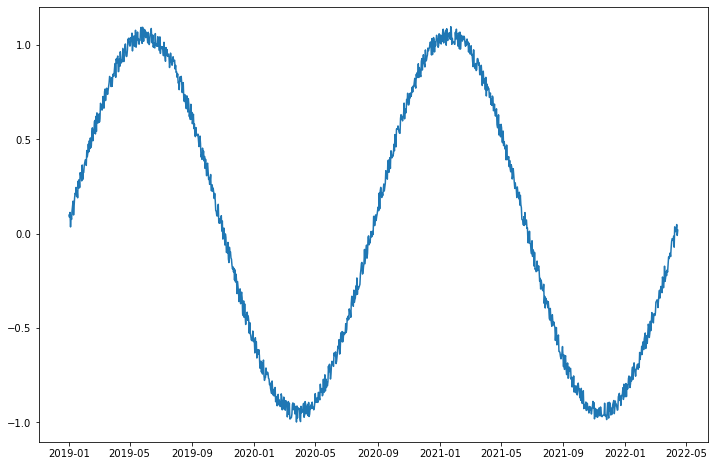

In [12]:
plt.figure(figsize=(12,8))
plt.plot(df)

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
rdata = scaler.fit_transform(np.array(df).reshape(-1,1))
# Prepare the data sets 
training_size=int(len(rdata)*0.80)
train_period,test_period=rdata[:training_size],rdata[training_size:]

In [35]:
from keras.preprocessing.sequence import TimeseriesGenerator
train = TimeseriesGenerator(train_period, train_period, length=10, batch_size=1000)
test = TimeseriesGenerator(test_period, test_period, length=10, batch_size=1000)
X_train, y_train = list(train)[0][0], list(train)[0][1]
X_test, y_test = list(test)[0][0], list(test)[0][1]

In [36]:
from numpy import insert
# Delete the first four values of y_train
y_train = np.delete(y_train,[0,1,2,3,],axis = 0)
len(y_train)

946

In [37]:
# Delete the last four time series of X_train
X_train = X_train[:-4, :]
len(X_train)

946

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [40]:
# Build LSTM model with training daata
model=Sequential() 
model.add(LSTM(50,return_sequences=True,activation='relu',input_shape=(10,1))) 
model.add(LSTM(50,return_sequences=True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',optimizer='adam')

In [112]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=40,batch_size=32,verbose=True)

Epoch 1/40
30/30 [==============================] - 6s 39ms/step - loss: 0.1258 - val_loss: 0.0303
Epoch 2/40
30/30 [==============================] - 0s 11ms/step - loss: 0.0085 - val_loss: 0.0039
Epoch 3/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 4/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 8.8983e-04
Epoch 5/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 6/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 6.6820e-04
Epoch 7/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 9.2054e-04
Epoch 8/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 9.0026e-04
Epoch 9/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 

In [42]:
# Predict the prices for the testing data set
train_predict = scaler.inverse_transform(model.predict(X_train))
test_predict = scaler.inverse_transform(model.predict(X_test))

8/8 [==============================] - 0s 3ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

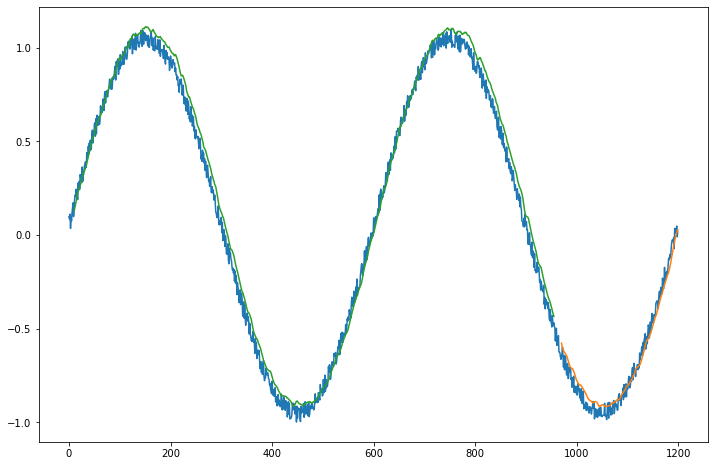

In [43]:
# Plot the actual/prediction graph and calculate the accuracy of prediction
look_back=10
trainPredictPlot=np.empty_like(rdata)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

testPredictPlot=np.empty_like(rdata)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+4:len(rdata)] = test_predict


plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(rdata))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)

plt.show


In [44]:
testPredictPlot.shape


(1200, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

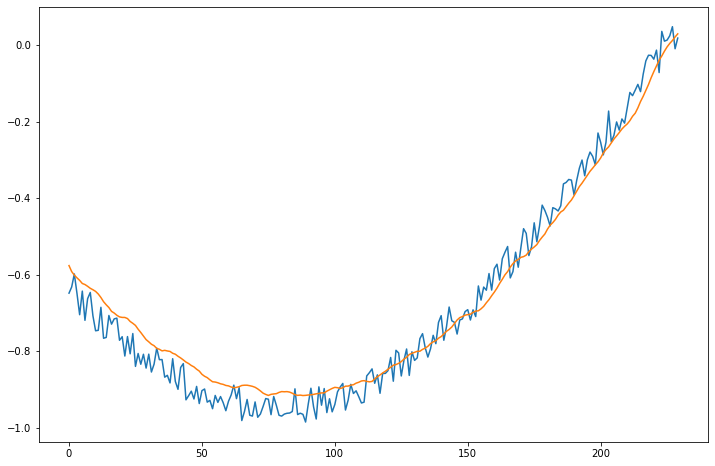

In [45]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(rdata)[len(train_predict)+(look_back*2)+4:len(rdata)])

plt.plot(test_predict)
plt.show

In [46]:
# Accuracy
np.sum(abs(test_predict-y_test))

188.263499723424